In [1]:
import numpy as np
import pandas as pd
from numba import jit

@jit
def jaccard(m1, m2):

    k1min = min(m1)
    k1max = max(m1)
    k2min = min(m2)
    k2max = max(m2)

    k1 = k1max - k1min + 1
    k2 = k2max - k2min + 1
    tab = np.zeros((k1,k2), dtype=np.uint32)

    for i in range(len(m1)):
        tab[(m1[i]-k1min),(m2[i]-k2min)] += 1
    dotp0 = np.sum(tab*(tab-1))
    tab1 = np.sum(tab, axis=1)
    tab2 = np.sum(tab, axis=0)
    dotp1 = np.sum(tab1*(tab1-1))
    dotp2 = np.sum(tab2*(tab2-1))

    return dotp0/(dotp1+dotp2-dotp0)

@jit
def matching(m1, m2):

    k1min = min(m1)
    k1max = max(m1)
    k2min = min(m2)
    k2max = max(m2)

    k1 = k1max - k1min + 1
    k2 = k2max - k2min + 1
    tab = np.zeros((k1,k2), dtype=np.uint32)

    for i in range(len(m1)):
        tab[(m1[i]-k1min),(m2[i]-k2min)] += 1
    dotp0 = np.sum(tab*(tab-1))
    tab1 = np.sum(tab, axis=1)
    tab2 = np.sum(tab, axis=0)
    dotp1 = np.sum(tab1*(tab1-1))
    dotp2 = np.sum(tab2*(tab2-1))

    n = len(m1)
    # M = 1 - (1/n^2)||C1 - C2||^2
    # M = 1 - (1/n^2)(<C1-C2,C1-C2>)
    # M = 1 - (1/n^2)(<C1,C1> - 2<C1,C2> + <C2,C2>)
    return 1 - (dotp1 - 2*dotp0 + dotp2)/(n**2)

    # M = (N00 + N11)/(N00 + N01 + N10 + N11)
    # M = (<1-C1, 1-C2> + <C1, C2>) / (<1-C1, 1-C2> + <1-C1, C2> + <C1, 1-C2> + <C1, C2>)
    # M = (<1, 1> - <1, C2> - <C1, 1> + <C1, C2> + <C1, C2>) /
    #     (<1, 1> - <1, C2> - <C1, 1> + <C1, C2> + <1, C2> - <C1, C2> + <C1, 1> - <C1, C2> + <C1, C2>)
    # M = (<1, 1> - <1, C2> - <C1, 1> + <C1, C2> + <C1, C2>) /
    #     (<1, 1>)
    # M = (n^2 - dotp2 - dotp1 + 2dotp0) / n^2

@jit
def cosine(m1, m2):

    k1min = min(m1)
    k1max = max(m1)
    k2min = min(m2)
    k2max = max(m2)

    k1 = k1max - k1min + 1
    k2 = k2max - k2min + 1
    tab = np.zeros((k1,k2), dtype=np.uint32)

    for i in range(len(m1)):
        tab[(m1[i]-k1min),(m2[i]-k2min)] += 1
    tab1 = np.sum(tab, axis=1)
    tab2 = np.sum(tab, axis=0)
    dotp0 = np.sum(tab*(tab-1))
    dotp1 = np.sum(tab1*(tab1-1))
    dotp2 = np.sum(tab2*(tab2-1))

    return dotp0/np.sqrt(dotp1*dotp2)

In [2]:
# read in lotla miami data
lotla_miami = np.loadtxt("../lfi-values/fulldata/rf/seed0/361260/" + \
    "elastic_nonnormed_nosquared_norank.csv", delimiter=",")
cols_miami = ['LATITUDE', 'LONGITUDE', 'LND_SQFOOT', 'TOT_LVG_AREA',
              'SPEC_FEAT_VAL', 'RAIL_DIST', 'OCEAN_DIST', 'WATER_DIST',
              'CNTR_DIST', 'SUBCNTR_DI', 'HWY_DIST', 'age', 'avno60plus',
              'month_sold', 'structure_quality']

In [3]:
# add ID column
lotla_miami = np.insert(lotla_miami, 0, np.arange(1, lotla_miami.shape[0] + 1), axis=1)

In [4]:
lotla_miami = pd.DataFrame(lotla_miami, columns=["ID"] + cols_miami)
lotla_miami

,ID,LATITUDE,LONGITUDE,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,1.0,0.002149,-0.057531,-0.034007,0.073368,-0.039719,0.034659,-0.024910,-0.000348,-0.028498,-0.163258,-0.029329,0.181405,-0.000008,0.001948,-0.155065
1,2.0,0.026698,0.033753,-0.046372,0.020439,-0.043538,-0.010077,-0.047728,0.004229,0.024642,0.088385,-0.042178,-0.121882,-0.000361,-0.017895,0.042531
2,3.0,0.063816,0.058237,-0.045046,-0.209148,-0.042282,0.008540,0.035089,-0.001086,0.042429,0.324997,0.019505,-0.175995,0.000393,-0.017181,0.031746
3,4.0,0.010801,0.196756,0.015185,0.011668,-0.054608,-0.006508,0.018517,0.024693,0.077173,0.082971,0.034121,-0.032200,-0.000008,-0.003535,0.046651
4,5.0,0.012042,-0.050396,0.025648,-0.272278,-0.017766,0.022891,-0.038275,0.003284,-0.020116,-0.198533,-0.036654,-0.091560,-0.000008,-0.003883,-0.162247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6961,6962.0,0.066805,0.063303,-0.018891,-0.357419,-0.040235,-0.012319,-0.023526,-0.003783,0.025594,0.125968,-0.039259,-0.159637,-0.000008,0.007367,0.053874
6962,6963.0,-0.003380,-0.083256,-0.041516,0.215034,-0.042328,0.021092,-0.018036,0.007177,-0.034146,-0.221144,-0.004772,0.169524,-0.000008,0.020431,-0.153225
6963,6964.0,-0.059764,0.091897,-0.028821,-0.335172,-0.048174,-0.001615,-0.009818,0.007476,0.014445,-0.047313,0.041915,-0.163307,-0.000008,-0.003589,0.054142
6964,6965.0,-0.010092,-0.064758,0.114512,0.339763,-0.041574,-0.000369,-0.027801,-0.002903,-0.041336,-0.083639,0.036938,0.166130,-0.000008,0.006173,-0.147550


In [5]:
# import kmeans
from sklearn.cluster import KMeans

In [6]:
def algorithm1(k, m, data, similarity_func):
    """
    Computes the clustering similarities using k-means.
    
    Args:
        k (int): Number of clusters
        m (float): Proportion of data
        data (pd.DataFrame): lotla data with at least an 'ID' column
        similarity_func (function): Similarity function to use
    
    Returns:
        np.ndarray: A vector of similarity scores
    """
    np.random.seed(0)
    
    num_rows, num_cols = data.shape
    
    N = 100  # Number of repetitions
    jaccard_vector = np.full(N, np.nan)  # Initialize similarity vector with NaNs
    
    for i in range(N):
        # Sample data
        idx1 = np.random.choice(num_rows, int(num_rows * m), replace=False)
        idx2 = np.random.choice(num_rows, int(num_rows * m), replace=False)
        
        # Get subsets
        sub1 = data.iloc[idx1].copy()
        sub2 = data.iloc[idx2].copy()
        
        # print(type(sub1))
        # print(sub1.columns)
        
        # Perform k-means clustering on the subsets (assuming columns start from index 6)
        kmeans1 = KMeans(n_clusters=k, random_state=0)
        kmeans2 = KMeans(n_clusters=k, random_state=0)
        
        # cluster on everything except the ID column        
        sub1_clusters = kmeans1.fit_predict(sub1.iloc[:, 1:num_cols])  
        sub2_clusters = kmeans2.fit_predict(sub2.iloc[:, 1:num_cols]) 
        
        # Assign the cluster labels to the data by creating new columns        
        sub1['cluster1'] = sub1_clusters
        sub2['cluster2'] = sub2_clusters
        
        # Perform an inner join based on 'ID' (assuming 'ID' column exists in the data)
        sub_intersect = pd.merge(sub1[['ID', 'cluster1']], sub2[['ID', 'cluster2']], on='ID')
        
        # Calculate Jaccard similarity
        jaccard_score = similarity_func(sub_intersect['cluster1'].to_numpy(),
                                        sub_intersect['cluster2'].to_numpy())
        
        jaccard_vector[i] = jaccard_score
    
    return jaccard_vector


In [7]:
from joblib import Parallel, delayed

In [8]:
# run algorithm1 in parallel for k=2,...,10
jaccard_scores = Parallel(n_jobs=-1)(delayed(algorithm1)(k, 0.8, lotla_miami, jaccard) for k in range(2, 11))

In [9]:
# run algorithm1 in parallel for k=2,...,10
matching_scores = Parallel(n_jobs=-1)(delayed(algorithm1)(k, 0.8, lotla_miami, matching) for k in range(2, 11))

In [10]:
cluster_jaccards = {k: jaccard_scores[k-2] for k in range(2, 11)}

In [11]:
cluster_matchings = {k: matching_scores[k-2] for k in range(2, 11)}

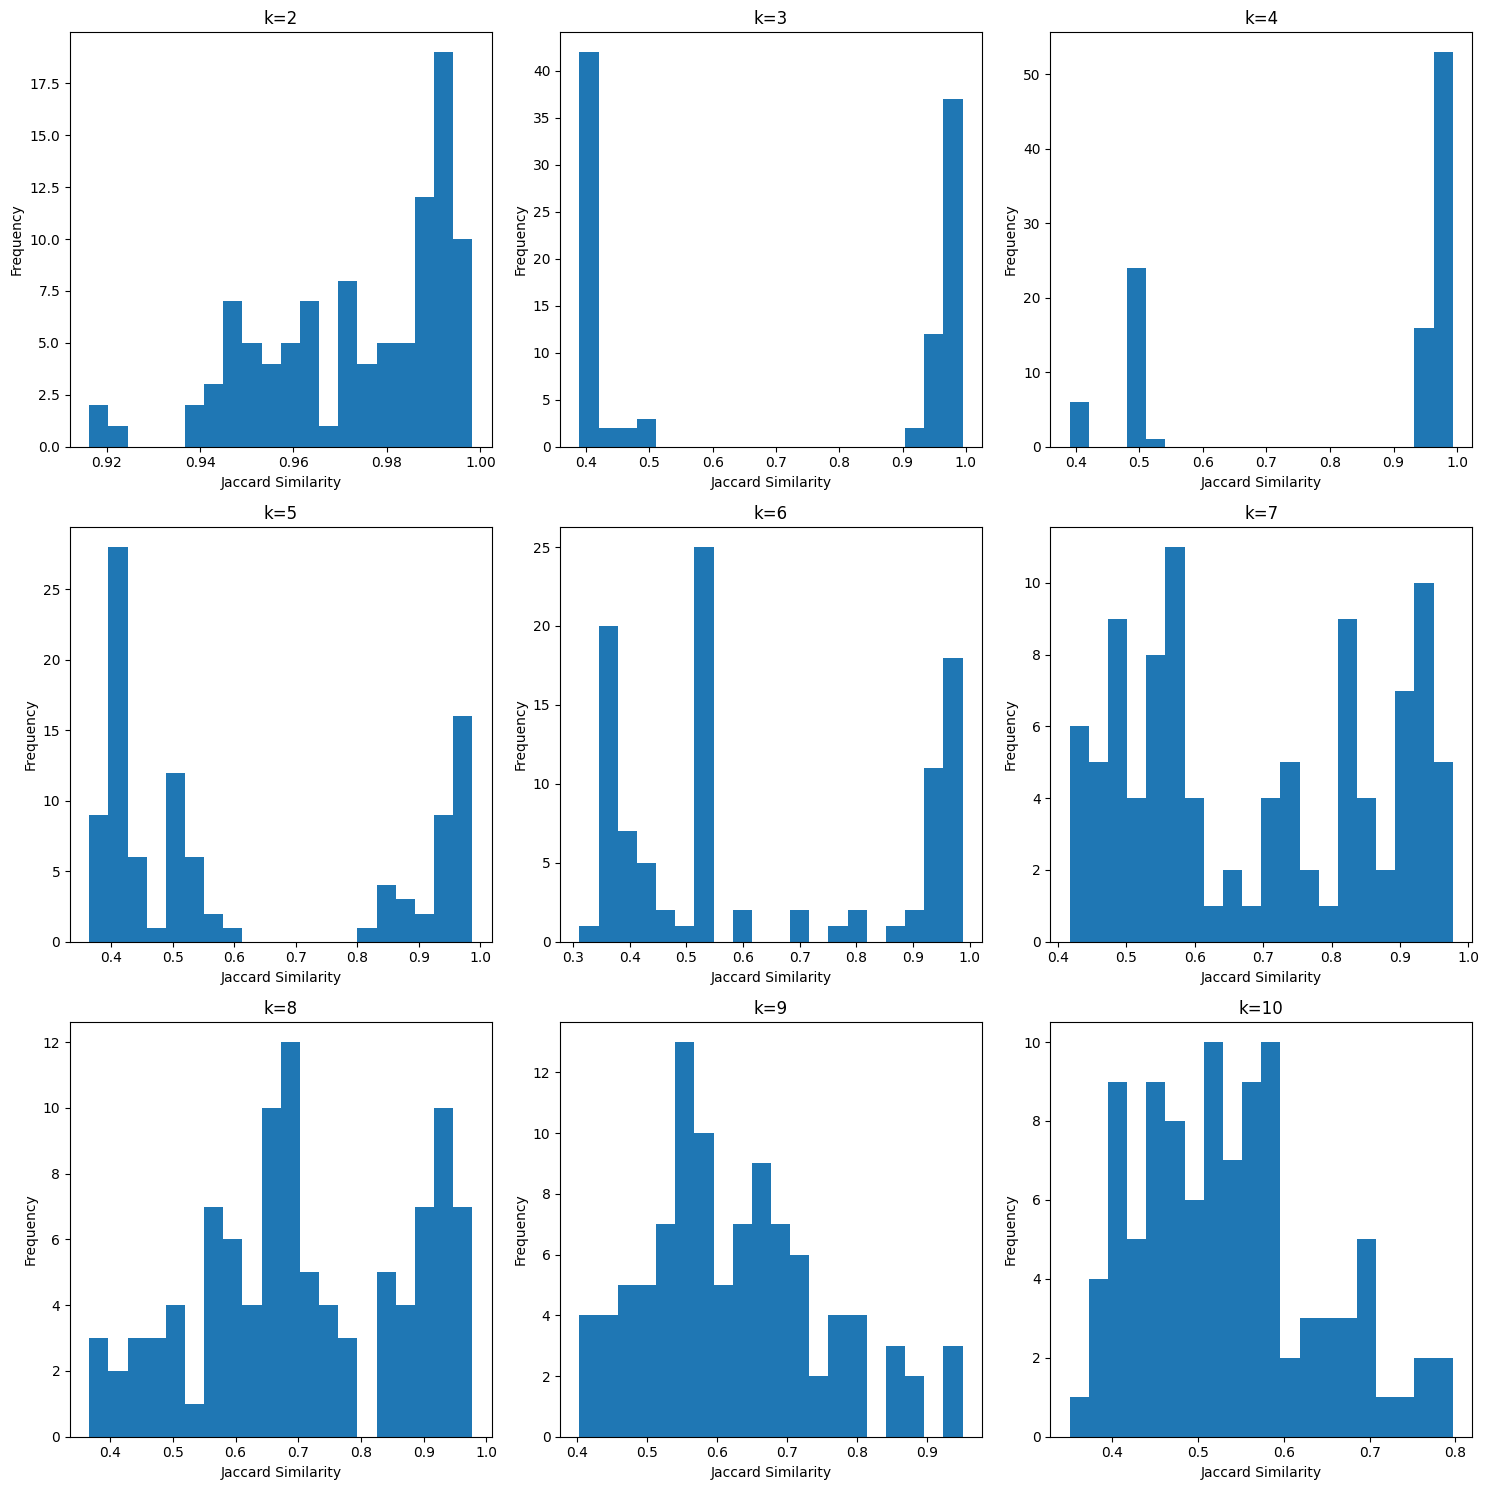

In [12]:
# make a histogram of the scores for each k
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

for i, (k, scores) in enumerate(cluster_jaccards.items()):
    axs[i].hist(scores, bins=20)
    axs[i].set_title(f"k={k}")
    axs[i].set_xlabel("Jaccard Similarity")
    axs[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


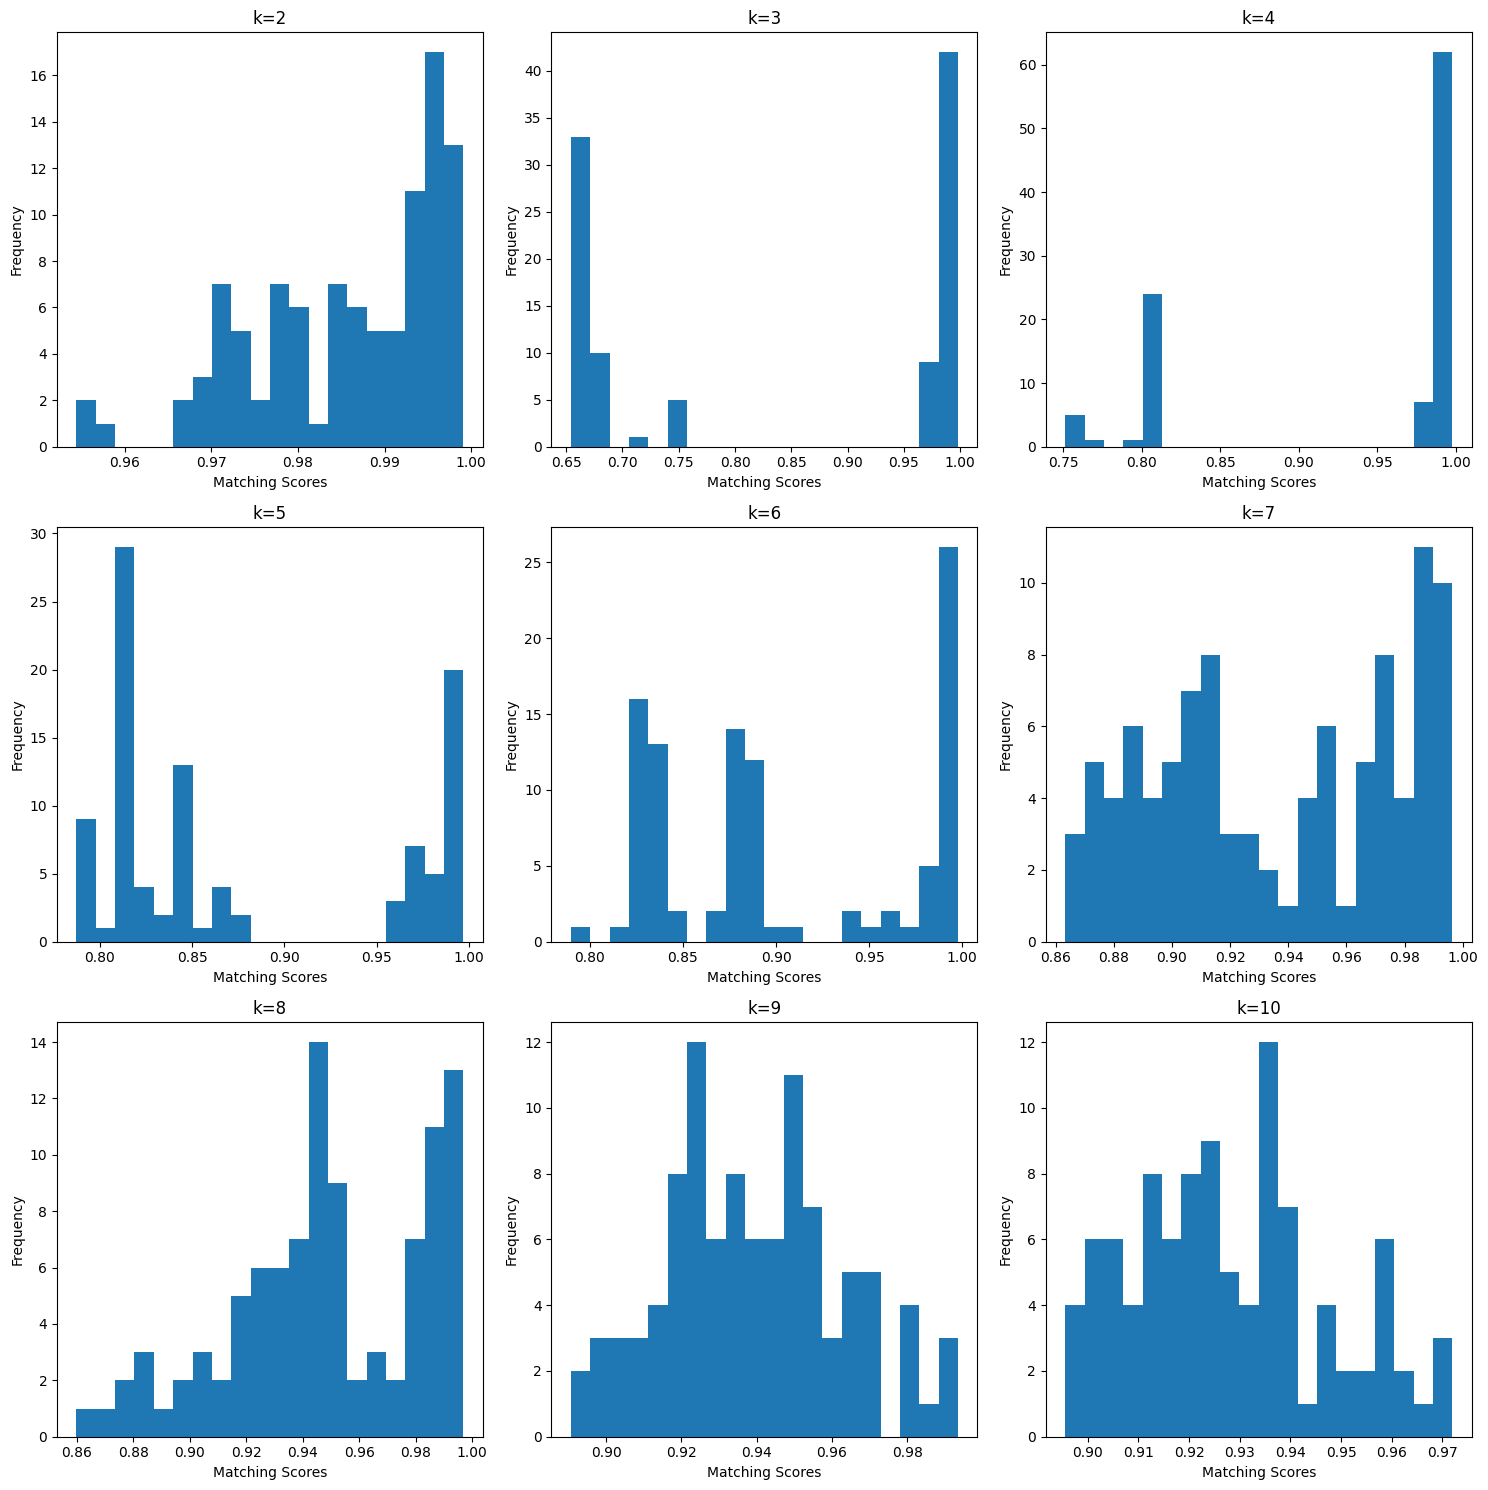

In [13]:
# make a histogram of the scores for each k
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

for i, (k, scores) in enumerate(cluster_matchings.items()):
    axs[i].hist(scores, bins=20)
    axs[i].set_title(f"k={k}")
    axs[i].set_xlabel("Matching Scores")
    axs[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


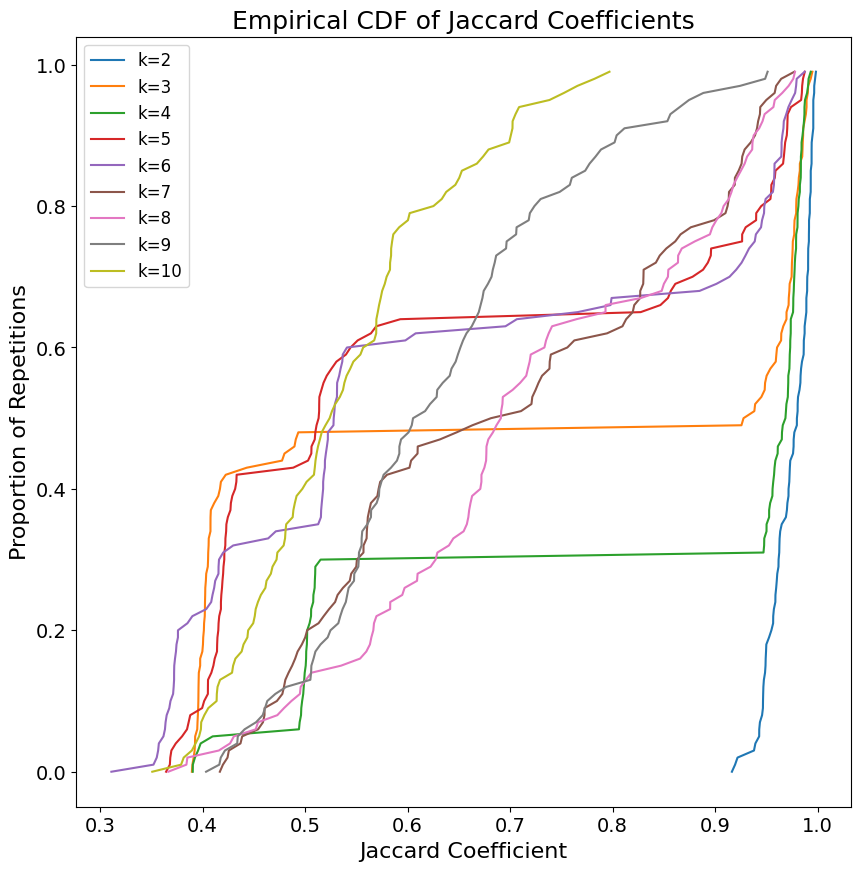

In [20]:
# plot the CDF of the jaccard coefficients, where each color is a different k
fig, ax = plt.subplots(figsize=(10, 10))

for k, scores in cluster_jaccards.items():
    scores = np.sort(scores)
    yvals = np.arange(len(scores))/float(len(scores))
    ax.plot(scores, yvals, label=f"k={k}")

ax.set_title("Empirical CDF of Jaccard Coefficients", size = 18)
ax.set_xlabel("Jaccard Coefficient", size=16)
ax.set_ylabel("Proportion of Repetitions", size=16)
# make the axis labels bigger
ax.tick_params(axis='both', which='major', labelsize=14)
# make legend text bigger
ax.legend(prop={'size': 12})
# ax.legend()
plt.show()